In [69]:
# Data manipulation
import pandas as pd
import numpy as np
# Evaluation of the model
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.size'] = 18
%matplotlib inline

MAX_EVALS = 20
import csv
from hyperopt import STATUS_OK
from timeit import default_timer as timer



DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [70]:
import json
import shlex
import subprocess
import logging
from pprint import pprint
import re
import os


In [71]:
def runthebenchmark(hyperparameters):
    os.chdir('/home/dsinghvi/project/progress/active/../')
    storeinfile(hyperparameters)
    out=subprocess.Popen(["python3","read_config_general.py","-n 2","-c200 200 400 2 2 4 1"], shell=False, stdout=subprocess.PIPE)
    logging.basicConfig(level=logging.DEBUG)
    output=out.stdout.read().decode('utf-8')
    print("output"+output)
    if len(output.split(" ")) > 5:
        values = output.split(" ")
        value = float(values[6]*1024)/float(values[5]) + float(values[3]*1024)/float(values[2])
        value = float(value)
        print(value)
        return float(value**3)
        #return float((100*100*100)/(value*value*value))
    return 0;
    #logging.basicConfig(filename='app.log', filemode='a', format='%(name)s - %(levelname)s - %(message)s',level=logging.DEBUG)


In [72]:
def storeinfile(hyperparameters):
    data={"mpi": {"romio_ds_read": "enable", "romio_ds_write": "disable"}, "lfs": {"setstripe": {"size": "16777216", "count": 4}}}
    data["lfs"]["setstripe"]["size"] = int(hyperparameters["setstripe-size"])
    data["lfs"]["setstripe"]["count"] = int(hyperparameters["setstripe-count"])

    data["mpi"]["romio_ds_read"] = hyperparameters["romio_ds_read"]
    data["mpi"]["romio_ds_write"] = hyperparameters["romio_ds_write"]
    data["mpi"]["romio_cb_read"] = hyperparameters["romio_cb_read"]
    data["mpi"]["romio_cb_write"] = hyperparameters["romio_cb_write"]
    data["mpi"]["cb_buffer_size"] = str(int(hyperparameters["cb_buffer_size"]))
    with open("confex.json","w") as fp:
        json.dump(data,fp)
    print(data)


In [73]:
def objective(hyperparameters):
    global ITERATION
    ITERATION += 1
    start = timer()
    result=0
    while(result == 0):
        print("rerun")
        result = runthebenchmark(hyperparameters)
        print(result)
    run_time = timer() - start
    print({'loss': result, 'hyperparameters': hyperparameters, 'iteration': ITERATION, 'iteration_time': run_time, 'status': STATUS_OK})
    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([float(result), hyperparameters, ITERATION, run_time])
    return {'loss': float(result), 'hyperparameters': hyperparameters, 'iteration': ITERATION, 'iteration_time': run_time, 'status': STATUS_OK}


In [74]:
from hyperopt import hp
from hyperopt.pyll.stochastic import sample

space = {
    'romio_ds_read' : hp.choice('romio_ds_read',['enable','disable']),
    'romio_ds_write' : hp.choice('romio_ds_write',['enable','disable']),
    'romio_cb_read' : hp.choice('romio_cb_read',['enable','disable']),
    'romio_cb_write' : hp.choice('romio_cb_write',['enable','disable']),
    'cb_buffer_size' : 1048576*hp.quniform('cb_buffer_size',1,512,1),
    'setstripe-size' : 65536*(hp.qloguniform('setstripe-size',0,3,1)),
    'setstripe-count' : hp.quniform('setstripe-count',0,20,1)
    
}

In [75]:
x = sample(space)
params = x
print(x)
cb_buffer_size_dist = []
for _ in range(1000):
    cb_buffer_size_dist.append(sample(space)['cb_buffer_size'])
setstripe_size_dist = []
for _ in range(1000):
    setstripe_size_dist.append(sample(space)['setstripe_size'])
setstripe_count_dist = []
for _ in range(1000):
    setstripe_count_dist.append(sample(space)['setstripe_count'])    

{'cb_buffer_size': 235929600.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'setstripe-count': 4.0, 'setstripe-size': 262144.0}


In [76]:
from hyperopt import tpe

# Create the algorithm
tpe_algorithm = tpe.suggest


from hyperopt import Trials

# Record results
bayes_trials = Trials()

In [77]:
# File to save first results
print(os.getcwd())
out_file = '/home/dsinghvi/project/progress/active/result/gbm_trials.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)
writer.writerow(['loss', 'params', 'iteration', 'train_time'])
of_connection.close()

/home/dsinghvi/project/progress


In [78]:
from hyperopt import fmin


ITERATION = 0

best = fmin(fn = objective, space = space, algo = tpe.suggest, trials = bayes_trials, max_evals = MAX_EVALS)

  0%|          | 0/20 [00:00<?, ?it/s, best loss: ?]

INFO:hyperopt.tpe:tpe_transform took 0.004619 seconds
INFO:hyperopt.tpe:TPE using 0 trials


rerun                                               
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '182452224'}, 'lfs': {'setstripe': {'size': 131072, 'count': 15}}}
outputS3D-IO 200-200-400-2-2-4-1 657.02 1.91 2.97 585.24 5.72 10.01 0.04 0.06 131072 15 disable enable enable disable 182452224 

0.012680833260727466                                
2.0391227793914057e-06                              
{'loss': 2.0391227793914057e-06, 'hyperparameters': {'cb_buffer_size': 182452224.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'setstripe-count': 15.0, 'setstripe-size': 131072.0}, 'iteration': 1, 'iteration_time': 17.79341949429363, 'status': 'ok'}
  5%|▌         | 1/20 [00:17<05:38, 17.81s/it, best loss: 2.0391227793914057e-06]

INFO:hyperopt.tpe:tpe_transform took 0.013125 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 0.000002


rerun                                                                            
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '159383552'}, 'lfs': {'setstripe': {'size': 458752, 'count': 7}}}
outputS3D-IO 200-200-400-2-2-4-1 704.45 1.91 2.77 735.03 5.72 7.97 0.04 0.13 458752 7 enable enable disable enable 159383552 

0.01049333037681731                                                              
1.1554204230776467e-06                                                           
{'loss': 1.1554204230776467e-06, 'hyperparameters': {'cb_buffer_size': 159383552.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 7.0, 'setstripe-size': 458752.0}, 'iteration': 2, 'iteration_time': 15.368536981754005, 'status': 'ok'}
 10%|█         | 2/20 [00:33<05:07, 17.09s/it, best loss: 1.1554204230776467e-06]

INFO:hyperopt.tpe:tpe_transform took 0.011597 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 0.000001


rerun                                                                            
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'cb_buffer_size': '244318208'}, 'lfs': {'setstripe': {'size': 131072, 'count': 13}}}
outputS3D-IO 200-200-400-2-2-4-1 652.12 1.91 3.00 615.88 5.72 9.51 0.04 0.10 131072 13 disable disable enable enable 244318208 

0.012216432333340733                                                             
1.8231952527101807e-06                                                           
{'loss': 1.8231952527101807e-06, 'hyperparameters': {'cb_buffer_size': 244318208.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'setstripe-count': 13.0, 'setstripe-size': 131072.0}, 'iteration': 3, 'iteration_time': 17.3392443228513, 'status': 'ok'}
 15%|█▌        | 3/20 [00:50<04:51, 17.17s/it, best loss: 1.1554204230776467e-06]

INFO:hyperopt.tpe:tpe_transform took 0.010517 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 0.000001


rerun                                                                            
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': '447741952'}, 'lfs': {'setstripe': {'size': 196608, 'count': 3}}}
outputS3D-IO 200-200-400-2-2-4-1 710.03 1.91 2.75 740.40 5.72 7.91 0.04 0.05 196608 3 disable enable disable disable 447741952 

0.010415580936677233                                                             
1.1299272804018814e-06                                                           
{'loss': 1.1299272804018814e-06, 'hyperparameters': {'cb_buffer_size': 447741952.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'setstripe-count': 3.0, 'setstripe-size': 196608.0}, 'iteration': 4, 'iteration_time': 15.287835768423975, 'status': 'ok'}
 20%|██        | 4/20 [01:05<04:25, 16.62s/it, best loss: 1.1299272804018814e-06]

INFO:hyperopt.tpe:tpe_transform took 0.009950 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 0.000001


rerun                                                                            
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '232783872'}, 'lfs': {'setstripe': {'size': 393216, 'count': 5}}}
outputS3D-IO 200-200-400-2-2-4-1 631.18 1.91 3.09 781.78 5.72 7.49 0.07 0.18 393216 5 enable enable enable disable 232783872 

0.010342714533228426                                                             
1.1063782104432977e-06                                                           
{'loss': 1.1063782104432977e-06, 'hyperparameters': {'cb_buffer_size': 232783872.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 5.0, 'setstripe-size': 393216.0}, 'iteration': 5, 'iteration_time': 15.35701375734061, 'status': 'ok'}
 25%|██▌       | 5/20 [01:21<04:03, 16.25s/it, best loss: 1.1063782104432977e-06]

INFO:hyperopt.tpe:tpe_transform took 0.006017 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 0.000001


rerun                                                                            
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': '97517568'}, 'lfs': {'setstripe': {'size': 917504, 'count': 17}}}
outputS3D-IO 200-200-400-2-2-4-1 621.99 1.91 3.14 143.31 5.72 40.89 0.05 0.12 917504 17 enable enable disable disable 97517568 

0.04298426320594776                                                              
7.94197399459177e-05                                                             
{'loss': 7.94197399459177e-05, 'hyperparameters': {'cb_buffer_size': 97517568.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 17.0, 'setstripe-size': 917504.0}, 'iteration': 6, 'iteration_time': 48.635577091015875, 'status': 'ok'}
 30%|███       | 6/20 [02:09<06:03, 25.97s/it, best loss: 1.1063782104432977e-06]

INFO:hyperopt.tpe:tpe_transform took 0.011184 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 0.000001


rerun                                                                            
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '231735296'}, 'lfs': {'setstripe': {'size': 983040, 'count': 18}}}
outputS3D-IO 200-200-400-2-2-4-1 611.80 1.91 3.19 183.83 5.72 31.87 0.07 0.12 983040 18 enable enable enable disable 231735296 

0.03423764000015862                                                              
4.013390916324599e-05                                                            
{'loss': 4.013390916324599e-05, 'hyperparameters': {'cb_buffer_size': 231735296.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 18.0, 'setstripe-size': 983040.0}, 'iteration': 7, 'iteration_time': 39.665239156223834, 'status': 'ok'}
 35%|███▌      | 7/20 [02:49<06:31, 30.09s/it, best loss: 1.1063782104432977e-06]

INFO:hyperopt.tpe:tpe_transform took 0.011036 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 0.000001


rerun                                                                            
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'cb_buffer_size': '154140672'}, 'lfs': {'setstripe': {'size': 131072, 'count': 12}}}
outputS3D-IO 200-200-400-2-2-4-1 693.84 1.91 2.82 627.78 5.72 9.33 0.04 0.09 131072 12 disable disable enable enable 154140672 

0.011864268205447627                                                             
1.6700245964721154e-06                                                           
{'loss': 1.6700245964721154e-06, 'hyperparameters': {'cb_buffer_size': 154140672.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'setstripe-count': 12.0, 'setstripe-size': 131072.0}, 'iteration': 8, 'iteration_time': 16.79045313131064, 'status': 'ok'}
 40%|████      | 8/20 [03:06<05:13, 26.11s/it, best loss: 1.1063782104432977e-06]

INFO:hyperopt.tpe:tpe_transform took 0.009092 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 0.000001


rerun                                                                            
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '59768832'}, 'lfs': {'setstripe': {'size': 458752, 'count': 13}}}
outputS3D-IO 200-200-400-2-2-4-1 556.84 1.91 3.51 420.51 5.72 13.93 0.17 0.04 458752 13 enable enable disable enable 59768832 

0.01703259993977608                                                              
4.941318382991388e-06                                                            
{'loss': 4.941318382991388e-06, 'hyperparameters': {'cb_buffer_size': 59768832.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 13.0, 'setstripe-size': 458752.0}, 'iteration': 9, 'iteration_time': 22.181697318330407, 'status': 'ok'}
 45%|████▌     | 9/20 [03:28<04:34, 24.94s/it, best loss: 1.1063782104432977e-06]

INFO:hyperopt.tpe:tpe_transform took 0.011676 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 0.000001


rerun                                                                            
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': '214958080'}, 'lfs': {'setstripe': {'size': 524288, 'count': 20}}}
outputS3D-IO 200-200-400-2-2-4-1 706.94 1.91 2.76 118.26 5.72 49.55 0.04 0.09 524288 20 enable disable disable disable 214958080 

0.051069787864472985                                                             
0.000133196300209316                                                             
{'loss': 0.000133196300209316, 'hyperparameters': {'cb_buffer_size': 214958080.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'setstripe-count': 20.0, 'setstripe-size': 524288.0}, 'iteration': 10, 'iteration_time': 56.95530547760427, 'status': 'ok'}
 50%|█████     | 10/20 [04:25<05:45, 34.55s/it, best loss: 1.1063782104432977e-06]

INFO:hyperopt.tpe:tpe_transform took 0.010347 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss 0.000001


rerun                                                                             
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': '213909504'}, 'lfs': {'setstripe': {'size': 262144, 'count': 11}}}
outputS3D-IO 200-200-400-2-2-4-1 634.57 1.91 3.08 686.14 5.72 8.54 0.04 0.03 262144 11 enable disable disable disable 213909504 

0.011346403319137503                                                              
1.460745815166901e-06                                                             
{'loss': 1.460745815166901e-06, 'hyperparameters': {'cb_buffer_size': 213909504.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'setstripe-count': 11.0, 'setstripe-size': 262144.0}, 'iteration': 11, 'iteration_time': 16.32841975055635, 'status': 'ok'}
 55%|█████▌    | 11/20 [04:42<04:21, 29.10s/it, best loss: 1.1063782104432977e-06]

INFO:hyperopt.tpe:tpe_transform took 0.010880 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss 0.000001


rerun                                                                             
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '137363456'}, 'lfs': {'setstripe': {'size': 131072, 'count': 13}}}
outputS3D-IO 200-200-400-2-2-4-1 595.65 1.91 3.28 644.78 5.72 9.09 0.03 0.13 131072 13 disable enable enable disable 137363456 

0.012077823950472818                                                              
1.7618384543718675e-06                                                            
{'loss': 1.7618384543718675e-06, 'hyperparameters': {'cb_buffer_size': 137363456.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'setstripe-count': 13.0, 'setstripe-size': 131072.0}, 'iteration': 12, 'iteration_time': 17.0447253677994, 'status': 'ok'}
 60%|██████    | 12/20 [04:59<03:23, 25.49s/it, best loss: 1.1063782104432977e-06]

INFO:hyperopt.tpe:tpe_transform took 0.010507 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss 0.000001


rerun                                                                             
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '54525952'}, 'lfs': {'setstripe': {'size': 196608, 'count': 16}}}
outputS3D-IO 200-200-400-2-2-4-1 593.65 1.91 3.29 335.29 5.72 17.48 0.16 0.09 196608 16 enable enable enable disable 54525952 

0.020277242610302688                                                              
8.337324250088937e-06                                                             
{'loss': 8.337324250088937e-06, 'hyperparameters': {'cb_buffer_size': 54525952.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 16.0, 'setstripe-size': 196608.0}, 'iteration': 13, 'iteration_time': 25.631063429638743, 'status': 'ok'}
 65%|██████▌   | 13/20 [05:24<02:58, 25.54s/it, best loss: 1.1063782104432977e-06]

INFO:hyperopt.tpe:tpe_transform took 0.010751 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss 0.000001


rerun                                                                             
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '223346688'}, 'lfs': {'setstripe': {'size': 589824, 'count': 17}}}
outputS3D-IO 200-200-400-2-2-4-1 615.89 1.91 3.17 591.83 5.72 9.90 0.04 0.04 589824 17 disable disable enable disable 223346688 

0.012766140703454729                                                              
2.080553463499373e-06                                                             
{'loss': 2.080553463499373e-06, 'hyperparameters': {'cb_buffer_size': 223346688.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'setstripe-count': 17.0, 'setstripe-size': 589824.0}, 'iteration': 14, 'iteration_time': 17.77639433555305, 'status': 'ok'}
 70%|███████   | 14/20 [05:42<02:19, 23.22s/it, best loss: 1.1063782104432977e-06]

INFO:hyperopt.tpe:tpe_transform took 0.010132 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss 0.000001


rerun                                                                             
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'cb_buffer_size': '326107136'}, 'lfs': {'setstripe': {'size': 131072, 'count': 19}}}
outputS3D-IO 200-200-400-2-2-4-1 701.71 1.91 2.78 599.42 5.72 9.78 0.04 0.10 131072 19 enable disable enable enable 326107136 

0.012264479967455735                                                              
1.8447920337375496e-06                                                            
{'loss': 1.8447920337375496e-06, 'hyperparameters': {'cb_buffer_size': 326107136.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'setstripe-count': 19.0, 'setstripe-size': 131072.0}, 'iteration': 15, 'iteration_time': 17.237110727466643, 'status': 'ok'}
 75%|███████▌  | 15/20 [05:59<01:47, 21.44s/it, best loss: 1.1063782104432977e-06]

INFO:hyperopt.tpe:tpe_transform took 0.010040 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss 0.000001


rerun                                                                             
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'cb_buffer_size': '216006656'}, 'lfs': {'setstripe': {'size': 65536, 'count': 18}}}
outputS3D-IO 200-200-400-2-2-4-1 640.96 1.91 3.05 603.52 5.72 9.71 0.04 0.04 65536 18 disable disable enable enable 216006656 

0.012457635789158256                                                              
1.9333340023742756e-06                                                            
{'loss': 1.9333340023742756e-06, 'hyperparameters': {'cb_buffer_size': 216006656.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'setstripe-count': 18.0, 'setstripe-size': 65536.0}, 'iteration': 16, 'iteration_time': 17.407520584762096, 'status': 'ok'}
 80%|████████  | 16/20 [06:17<01:20, 20.24s/it, best loss: 1.1063782104432977e-06]

INFO:hyperopt.tpe:tpe_transform took 0.009946 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss 0.000001


rerun                                                                             
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '146800640'}, 'lfs': {'setstripe': {'size': 327680, 'count': 10}}}
outputS3D-IO 200-200-400-2-2-4-1 661.84 1.91 2.95 695.29 5.72 8.43 0.05 0.07 327680 10 disable disable enable disable 146800640 

0.01111267694056587                                                               
1.3723221310491843e-06                                                            
{'loss': 1.3723221310491843e-06, 'hyperparameters': {'cb_buffer_size': 146800640.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'setstripe-count': 10.0, 'setstripe-size': 327680.0}, 'iteration': 17, 'iteration_time': 16.060841751284897, 'status': 'ok'}
 85%|████████▌ | 17/20 [06:33<00:56, 18.99s/it, best loss: 1.1063782104432977e-06]

INFO:hyperopt.tpe:tpe_transform took 0.009869 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss 0.000001


rerun                                                                             
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '269484032'}, 'lfs': {'setstripe': {'size': 196608, 'count': 12}}}
outputS3D-IO 200-200-400-2-2-4-1 538.05 1.91 3.63 680.84 5.72 8.61 0.03 0.07 196608 12 disable enable enable disable 269484032 

0.011951242483872873                                                              
1.7070222197557033e-06                                                            
{'loss': 1.7070222197557033e-06, 'hyperparameters': {'cb_buffer_size': 269484032.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'setstripe-count': 12.0, 'setstripe-size': 196608.0}, 'iteration': 18, 'iteration_time': 16.81332257669419, 'status': 'ok'}
 90%|█████████ | 18/20 [06:50<00:36, 18.35s/it, best loss: 1.1063782104432977e-06]

INFO:hyperopt.tpe:tpe_transform took 0.012318 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss 0.000001


rerun                                                                             
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'cb_buffer_size': '472907776'}, 'lfs': {'setstripe': {'size': 393216, 'count': 15}}}
outputS3D-IO 200-200-400-2-2-4-1 737.13 1.91 2.65 635.29 5.72 9.22 0.04 0.12 393216 15 enable disable enable enable 472907776 

0.011594892526874623                                                              
1.5588351229181167e-06                                                            
{'loss': 1.5588351229181167e-06, 'hyperparameters': {'cb_buffer_size': 472907776.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'setstripe-count': 15.0, 'setstripe-size': 393216.0}, 'iteration': 19, 'iteration_time': 16.523416757583618, 'status': 'ok'}
 95%|█████████▌| 19/20 [07:06<00:17, 17.81s/it, best loss: 1.1063782104432977e-06]

INFO:hyperopt.tpe:tpe_transform took 0.013539 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss 0.000001


rerun                                                                             
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '149946368'}, 'lfs': {'setstripe': {'size': 131072, 'count': 2}}}
outputS3D-IO 200-200-400-2-2-4-1 727.76 1.91 2.68 765.09 5.72 7.66 0.04 0.07 131072 2 disable disable disable enable 149946368 

0.010100736215449655                                                              
1.0305263204374566e-06                                                            
{'loss': 1.0305263204374566e-06, 'hyperparameters': {'cb_buffer_size': 149946368.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'setstripe-count': 2.0, 'setstripe-size': 131072.0}, 'iteration': 20, 'iteration_time': 14.947573266923428, 'status': 'ok'}
100%|██████████| 20/20 [07:21<00:00, 16.96s/it, best loss: 1.0305263204374566e-06]


In [79]:
print(best)
d=  best
#print(bayes_trials.results)
bayes_trials_results = sorted(bayes_trials.results, key = lambda x: x['loss'])
#bayes_trials_results[:1]

{'cb_buffer_size': 143.0, 'romio_cb_read': 1, 'romio_cb_write': 0, 'romio_ds_read': 1, 'romio_ds_write': 1, 'setstripe-count': 2.0, 'setstripe-size': 2.0}


In [80]:
results = pd.read_csv(out_file)

# Sort with best scores on top and reset index for slicing
results.sort_values('train_time', ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)
results.head()


,loss,params,iteration,train_time
0,0.000001,"{'cb_buffer_size': 149946368.0, 'romio_cb_read...",20,14.947573
1,0.000001,"{'cb_buffer_size': 447741952.0, 'romio_cb_read...",4,15.287836
2,0.000001,"{'cb_buffer_size': 232783872.0, 'romio_cb_read...",5,15.357014
3,0.000001,"{'cb_buffer_size': 159383552.0, 'romio_cb_read...",2,15.368537
4,0.000001,"{'cb_buffer_size': 146800640.0, 'romio_cb_read...",17,16.060842


In [81]:
import ast

# Convert from a string to a dictionary
ast.literal_eval(results.loc[0, 'params'])
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()
print(best_bayes_params)

{'cb_buffer_size': 149946368.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'setstripe-count': 2.0, 'setstripe-size': 131072.0}


In [82]:
bayes_params = pd.DataFrame(columns = list(ast.literal_eval(results.loc[0, 'params']).keys()),
                            index = list(range(len(results))))

# Add the results with each parameter a different column
for i, params in enumerate(results['params']):
    bayes_params.loc[i, :] = list(ast.literal_eval(params).values())
bayes_params['train_time'] = results['train_time']    
bayes_params['loss'] = results['loss']
bayes_params['iteration'] = results['iteration']

bayes_params.head()

,cb_buffer_size,romio_cb_read,romio_cb_write,romio_ds_read,romio_ds_write,setstripe-count,setstripe-size,train_time,loss,iteration
0,1.49946e+08,disable,enable,disable,disable,2,131072,14.947573,0.000001,20
1,4.47742e+08,disable,disable,disable,enable,3,196608,15.287836,0.000001,4
2,2.32784e+08,enable,disable,enable,enable,5,393216,15.357014,0.000001,5
3,1.59384e+08,disable,enable,enable,enable,7,458752,15.368537,0.000001,2
4,1.46801e+08,enable,disable,disable,disable,10,327680,16.060842,0.000001,17


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


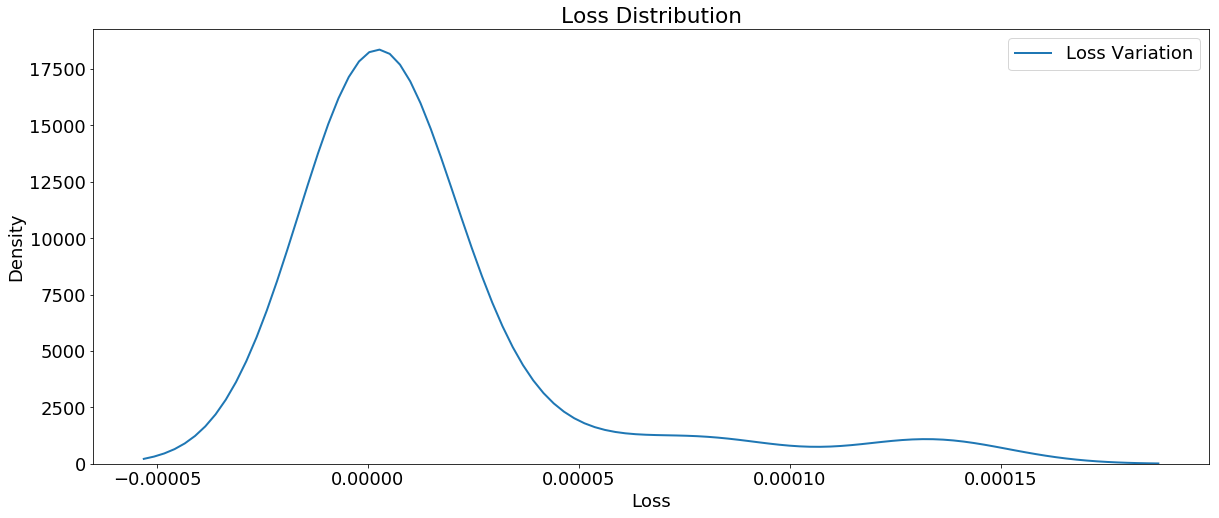

In [83]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

# Density plots of the learning rate distributions 
sns.kdeplot(bayes_params['loss'], label = 'Loss Variation', linewidth = 2)
plt.legend()
plt.xlabel('Loss'); plt.ylabel('Density'); plt.title('Loss Distribution');


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


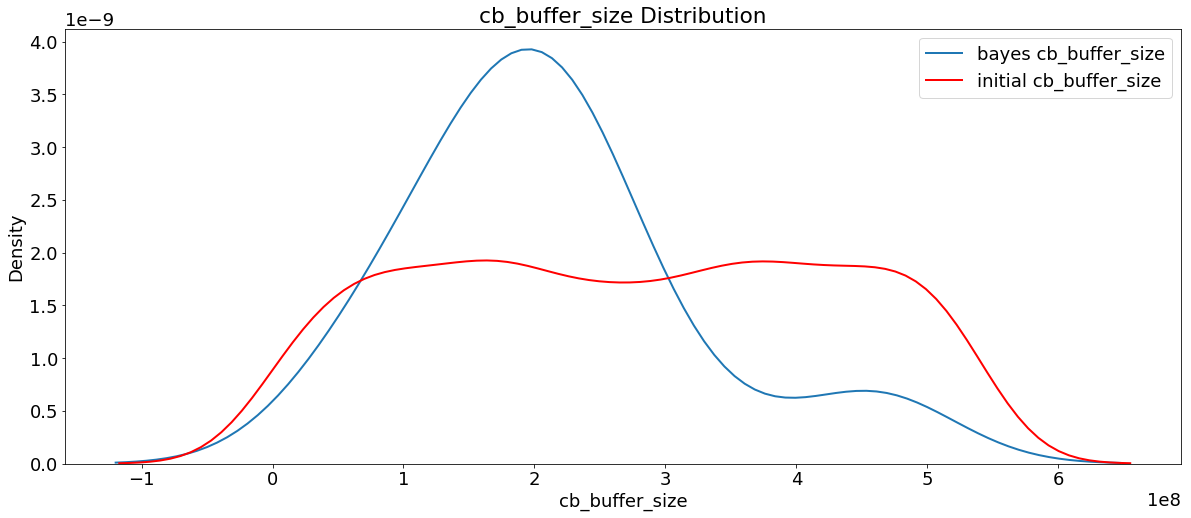

In [84]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18
#cb_buffer_size_dist_now = []
#for _ in range(30):
#    cb_buffer_size_dist_now.append(sample(space)['cb_buffer_size'])
# Density plots of the learning rate distributions 
sns.kdeplot(bayes_params['cb_buffer_size'], label = 'bayes cb_buffer_size', linewidth = 2)
sns.kdeplot(cb_buffer_size_dist,color="red",linewidth=2, label = 'initial cb_buffer_size')
#sns.kdeplot(cb_buffer_size_dist_now,color="green",linewidth=2, label= 'current cb_buffer_size')
plt.legend()
plt.xlabel('cb_buffer_size'); plt.ylabel('Density'); plt.title('cb_buffer_size Distribution');